In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning import LightningModule, LightningDataModule

from scipy import stats
import os
datadir = '../data/'
csv_file = '24_11_29-ABNB_5y_history.csv'

BATCH_SIZE=16


# log into to wandb to log results
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tomy-lorant (lorant). Use `wandb login --relogin` to force relogin


True

Pip commands to download libraries to access the data set from hugging face

In [2]:
!pip install pytorch-lightning

In [3]:
!pip install fsspec
!pip install huggingface_hub

In [4]:
# df = pd.read_csv("hf://datasets/nateraw/airbnb-stock-price/airbnb-stock-price.zip")
df = pd.read_csv("../data/24_11_29-ABNB_5y_history.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-12-10 00:00:00-05:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0
1,2020-12-11 00:00:00-05:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0
2,2020-12-14 00:00:00-05:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0
3,2020-12-15 00:00:00-05:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0
4,2020-12-16 00:00:00-05:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0


One problem I see is the format of the date. I need it to have a numerical value so that the model can understand it. After doing some research, I found that one way to do it is separating the date into three different features: day, month, and year.<br><br>

Then, I realized that simply splitting the date into three features lacks the key relationship of January being as close to December as June is to July, because it would interpret them as 0 and 11 being far apart and 5 and 6 as being close. A solution to this is applying the sine and cosine transformations to the days and moths to maintain the cyclic relationship property they have. 

In [6]:
type(df['Date'][0])

pattern = r"^\d{2}/\d{2}/\d{2}$"

invalid_dates = df['Date'][~df['Date'].str.match(pattern, na=False)]

# contains_slash = df['Date'][df['Date'].str.contains('-')]
print(invalid_dates.shape)
invalid_dates
print(df.head())
# test = pd.to_datetime(df['Date'], format='%m/%d/%y')
test = pd.to_datetime(df['Date'], utc=True)
test.head()

(999,)
                        Date        Open        High         Low       Close  \
0  2020-12-10 00:00:00-05:00  146.000000  165.000000  141.250000  144.710007   
1  2020-12-11 00:00:00-05:00  146.550003  151.500000  135.100006  139.250000   
2  2020-12-14 00:00:00-05:00  135.000000  135.300003  125.160004  130.000000   
3  2020-12-15 00:00:00-05:00  126.690002  127.599998  121.500000  124.800003   
4  2020-12-16 00:00:00-05:00  125.830002  142.000000  124.910004  137.990005   

     Volume  Dividends  Stock Splits  
0  70447500        0.0           0.0  
1  26980800        0.0           0.0  
2  16966100        0.0           0.0  
3  10914400        0.0           0.0  
4  20409600        0.0           0.0  


0   2020-12-10 05:00:00+00:00
1   2020-12-11 05:00:00+00:00
2   2020-12-14 05:00:00+00:00
3   2020-12-15 05:00:00+00:00
4   2020-12-16 05:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

In [7]:
# df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
df['Date'] = pd.to_datetime(df['Date'], utc=True)
print(type(df['Date'][0]))
print(df.head())

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
                       Date        Open        High         Low       Close  \
0 2020-12-10 05:00:00+00:00  146.000000  165.000000  141.250000  144.710007   
1 2020-12-11 05:00:00+00:00  146.550003  151.500000  135.100006  139.250000   
2 2020-12-14 05:00:00+00:00  135.000000  135.300003  125.160004  130.000000   
3 2020-12-15 05:00:00+00:00  126.690002  127.599998  121.500000  124.800003   
4 2020-12-16 05:00:00+00:00  125.830002  142.000000  124.910004  137.990005   

     Volume  Dividends  Stock Splits  
0  70447500        0.0           0.0  
1  26980800        0.0           0.0  
2  16966100        0.0           0.0  
3  10914400        0.0           0.0  
4  20409600        0.0           0.0  


In [8]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16


In [9]:
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)

df['day_sin'] = np.sin(2*np.pi*df['day']/7)
df['day_cos'] = np.cos(2*np.pi*df['day']/7)

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10,-2.449294e-16,1.0,4.338837e-01,-0.900969
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11,-2.449294e-16,1.0,-4.338837e-01,-0.900969
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14,-2.449294e-16,1.0,-4.898587e-16,1.000000
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15,-2.449294e-16,1.0,7.818315e-01,0.623490
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16,-2.449294e-16,1.0,9.749279e-01,-0.222521


In [10]:
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
import matplotlib.dates as mdates

# plt.plot(df['Date'], df['Adj.Close'])
# plt.xlabel('Date')
# plt.ylabel('Adj.Close')

# # Sets how often the dates should appear. (in this case it is every 30 days)
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
# # Format how the dates should appear
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # Rotate the date labels for better visibility
# plt.xticks(rotation=45)

# plt.show()

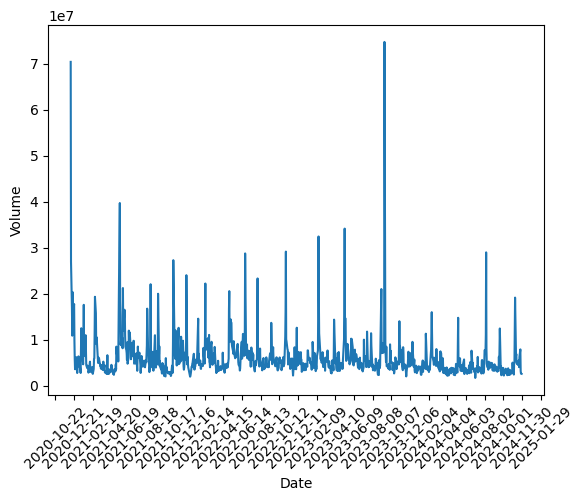

In [12]:
plt.plot(df['Date'], df['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

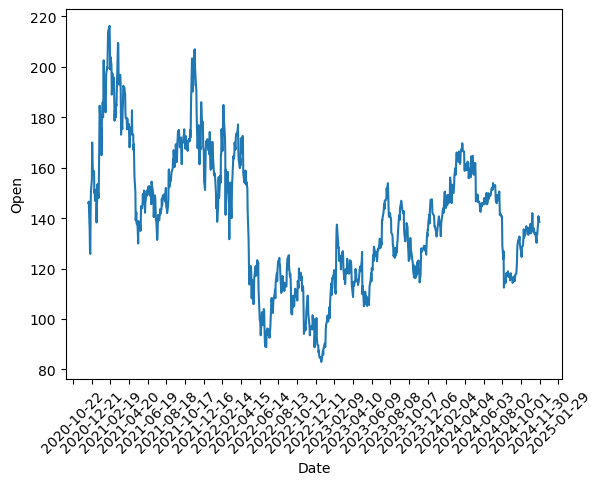

In [13]:
plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

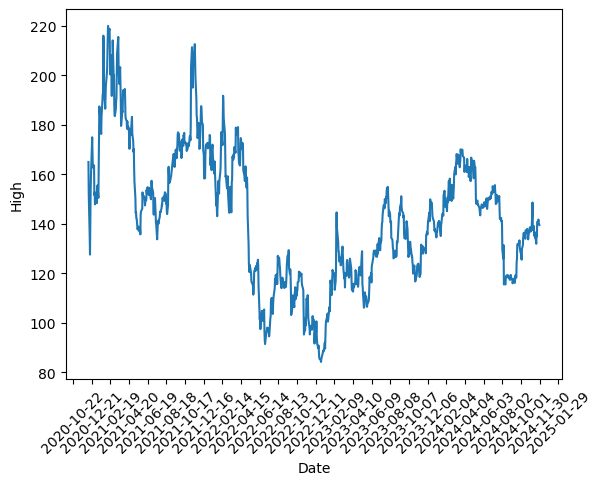

In [14]:
plt.plot(df['Date'], df['High'])
plt.xlabel('Date')
plt.ylabel('High')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

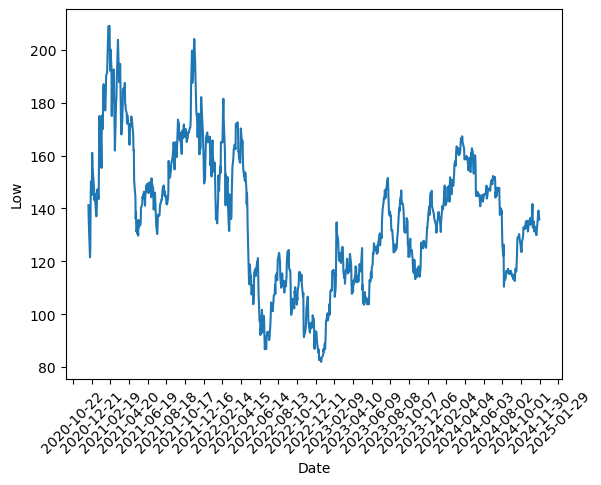

In [15]:
plt.plot(df['Date'], df['Low'])
plt.xlabel('Date')
plt.ylabel('Low')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [16]:
!pip install pytorch-lightning

The value this model will be predicting the stock's price change. Which is calculated with the following formula:<br><br>

$$ y = \frac{\text{Adj. Close}[t+1] - \text{Adj. Close}[t]}{\text{Adj. Close}[t]} $$

In [17]:
# df['price_change'] = df['Adj.Close'].pct_change()
df['price_change'] = df['Close'].pct_change()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10,-2.449294e-16,1.0,4.338837e-01,-0.900969,NaN
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11,-2.449294e-16,1.0,-4.338837e-01,-0.900969,-0.037731
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14,-2.449294e-16,1.0,-4.898587e-16,1.000000,-0.066427
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15,-2.449294e-16,1.0,7.818315e-01,0.623490,-0.040000
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16,-2.449294e-16,1.0,9.749279e-01,-0.222521,0.105689


In [18]:
nulls = df.isna().sum()
nulls

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
year            0
month           0
day             0
month_sin       0
month_cos       0
day_sin         0
day_cos         0
price_change    1
dtype: int64

In [19]:
df['price_change'] = df['price_change'].fillna(0)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10,-2.449294e-16,1.0,4.338837e-01,-0.900969,0.000000
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11,-2.449294e-16,1.0,-4.338837e-01,-0.900969,-0.037731
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14,-2.449294e-16,1.0,-4.898587e-16,1.000000,-0.066427
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15,-2.449294e-16,1.0,7.818315e-01,0.623490,-0.040000
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16,-2.449294e-16,1.0,9.749279e-01,-0.222521,0.105689


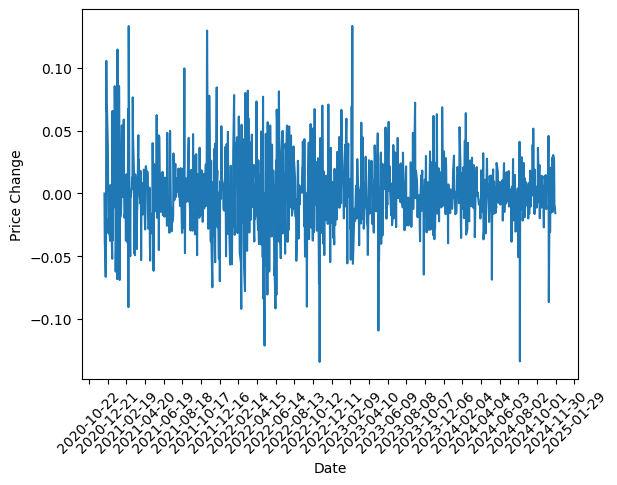

In [20]:
plt.plot(df['Date'], df['price_change'])
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

In [21]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10,-2.449294e-16,1.0,4.338837e-01,-0.900969,0.000000
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11,-2.449294e-16,1.0,-4.338837e-01,-0.900969,-0.037731
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14,-2.449294e-16,1.0,-4.898587e-16,1.000000,-0.066427
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15,-2.449294e-16,1.0,7.818315e-01,0.623490,-0.040000
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16,-2.449294e-16,1.0,9.749279e-01,-0.222521,0.105689


In [22]:
df['change'] = df['price_change'].apply(lambda x :  1 if x > 0 else 0)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change,change
0,2020-12-10 05:00:00+00:00,146.000000,165.000000,141.250000,144.710007,70447500,0.0,0.0,2020,12,10,-2.449294e-16,1.0,4.338837e-01,-0.900969,0.000000,0
1,2020-12-11 05:00:00+00:00,146.550003,151.500000,135.100006,139.250000,26980800,0.0,0.0,2020,12,11,-2.449294e-16,1.0,-4.338837e-01,-0.900969,-0.037731,0
2,2020-12-14 05:00:00+00:00,135.000000,135.300003,125.160004,130.000000,16966100,0.0,0.0,2020,12,14,-2.449294e-16,1.0,-4.898587e-16,1.000000,-0.066427,0
3,2020-12-15 05:00:00+00:00,126.690002,127.599998,121.500000,124.800003,10914400,0.0,0.0,2020,12,15,-2.449294e-16,1.0,7.818315e-01,0.623490,-0.040000,0
4,2020-12-16 05:00:00+00:00,125.830002,142.000000,124.910004,137.990005,20409600,0.0,0.0,2020,12,16,-2.449294e-16,1.0,9.749279e-01,-0.222521,0.105689,1


In [23]:
scaler = StandardScaler()

for column in df.columns:
    if column != 'change':
        df[column] = scaler.fit_transform(df[[column]])
    # print(column, ': max = ', t[column].max(), '  min = ', t[column].min())

Since I am trying to predict the future trends of the stock, I have to do a time-based split. What this means is making the testing data the values of the stock at earlier dates and the testing data the later values form the data set.

In [24]:
split_index1 = int(df.shape[0] * 0.2)
split_index2 = int(df.shape[0] * 0.1)

print(split_index1)
print(split_index2)

test_df = df.iloc[:split_index2]
val_df = df.iloc[split_index2:split_index1]
train_df = df.iloc[split_index1:]



print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(df.shape)


199
99
(800, 17)
(100, 17)
(99, 17)
(999, 17)


In [25]:
print(train_df.iloc[0])
print(val_df.iloc[0])

Date           -1.038339
Open            1.326557
High            1.233868
Low             1.357177
Close           1.299366
Volume         -0.513663
Dividends       0.000000
Stock Splits    0.000000
year           -1.253502
month           0.727699
day             1.283418
month_sin      -1.392776
month_cos       0.018993
day_sin        -1.200724
day_cos         0.872496
price_change   -0.310285
change          0.000000
Name: 199, dtype: float64
Date           -1.384399
Open            1.110529
High            1.007808
Low             0.970193
Close           0.845663
Volume         -0.505821
Dividends       0.000000
Stock Splits    0.000000
year           -1.253502
month          -0.444363
day            -1.231468
month_sin       0.715569
month_cos      -1.213709
day_sin        -1.472516
day_cos        -0.336069
price_change   -1.266760
change          0.000000
Name: 99, dtype: float64


In [26]:
print(test_df.iloc[0])

Date            -1.732747
Open             0.227470
High             0.817063
Low              0.154398
Close            0.175567
Volume          13.043133
Dividends        0.000000
Stock Splits     0.000000
year            -2.129813
month            1.606746
day             -0.659903
month_sin        0.012787
month_cos        1.442395
day_sin          0.510453
day_cos         -1.305263
price_change    -0.013531
change           0.000000
Name: 0, dtype: float64


In [27]:
test_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day,month_sin,month_cos,day_sin,day_cos,price_change,change
0,-1.732747,0.227470,0.817063,0.154398,0.175567,13.043133,0.0,0.0,-2.129813,1.606746,-0.659903,0.012787,1.442395,0.510453,-1.305263,-0.013531,0
1,-1.730360,0.248315,0.319945,-0.086001,-0.032080,4.234410,0.0,0.0,-2.129813,1.606746,-0.545590,0.012787,1.442395,-0.710971,-1.305263,-1.229129,0
2,-1.723201,-0.189425,-0.276596,-0.474549,-0.383862,2.204886,0.0,0.0,-2.129813,1.606746,-0.202651,0.012787,1.442395,-0.100259,1.410358,-2.153669,0
3,-1.720814,-0.504370,-0.560137,-0.617616,-0.581620,0.978482,0.0,0.0,-2.129813,1.606746,-0.088338,0.012787,1.442395,1.000206,0.872496,-1.302241,0
4,-1.718427,-0.536963,-0.029878,-0.484321,-0.079998,2.902727,0.0,0.0,-2.129813,1.606746,0.025975,0.012787,1.442395,1.271999,-0.336069,3.391535,1


In [28]:
class Data(Dataset):
    def __init__(self, df):
        # self.x = torch.tensor(df.drop(columns=['price_change','Date', 'Adj.Close','month', 'day', 'change', 'year']).values, dtype = torch.float32)
        self.x = torch.tensor(df.drop(columns=['price_change','Date','month', 'day', 'change', 'year', 'Dividends', 'Stock Splits']).values, dtype = torch.float32)
        self.y = torch.tensor(df['change'].values, dtype=torch.float32)
        self.len = df.shape[0]
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
train_ds = Data(train_df)
test_ds = Data(test_df)
val_ds = Data(val_df)

In [29]:
train_ds.y

tensor([0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 1., 1., 0., 

Test if the Dataset class and DataLoader works.

In [30]:
train_loader = DataLoader(train_ds,shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)
test = next(iter(train_loader))
test

[tensor([[ 1.3266,  1.2339,  1.3572,  1.2994, -0.5137, -1.3928,  0.0190, -1.2007,
           0.8725],
         [ 1.2324,  1.1323,  1.1570,  1.0834, -0.3492, -1.3928,  0.0190, -0.1003,
           1.4104],
         [ 1.1408,  1.0461,  1.1434,  1.0640, -0.6682, -1.3928,  0.0190,  1.0002,
           0.8725],
         [ 1.0651,  0.9828,  1.1105,  1.0518, -0.6938, -1.3928,  0.0190,  1.2720,
          -0.3361],
         [ 1.1488,  1.1190,  1.2215,  1.2518, -0.2276, -1.2045,  0.7307,  1.0002,
           0.8725],
         [ 1.2125,  1.0844,  1.0449,  0.9282, -0.3297, -1.2045,  0.7307, -0.7110,
          -1.3053],
         [ 0.9730,  0.8756,  0.9823,  0.9373, -0.3538, -1.2045,  0.7307, -1.4725,
          -0.3361],
         [ 0.8107,  0.9025,  0.9119,  1.0328, -0.7345, -1.2045,  0.7307, -1.2007,
           0.8725],
         [ 1.1371,  1.0479,  1.2235,  1.1221, -0.8038, -1.2045,  0.7307, -0.1003,
           1.4104],
         [ 1.1408,  1.1522,  1.2579,  1.1362, -0.7743, -1.2045,  0.7307,  1.0002,


In [31]:
class StockDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
    def prepare_data(self):
        # Download data
        if not os.path.exists(self.data_dir + csv_file):
            df = pd.read_csv("hf://datasets/nateraw/airbnb-stock-price/airbnb-stock-price.zip")
            df.to_csv(self.data_dir + csv_file, index=False)

    # Feature selection and engineering
    def setup(self, stage=None):
        self.prepare_data()
        df = pd.read_csv(self.data_dir + csv_file)
        
        # df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
        df['Date'] = pd.to_datetime(df['Date'], utc=True)
        df['year'] = df['Date'].dt.year
        df['month'] = df['Date'].dt.month
        df['day'] = df['Date'].dt.day

        df['month_sin'] = np.sin(2*np.pi*df['month']/12)
        df['month_cos'] = np.cos(2*np.pi*df['month']/12)

        df['day_sin'] = np.sin(2*np.pi*df['day']/7)
        df['day_cos'] = np.cos(2*np.pi*df['day']/7)

        # df['price_change'] = df['Adj.Close'].pct_change()
        df['price_change'] = df['Close'].pct_change()

        df['price_change'] = df['price_change'].fillna(0)

        df['change'] = df['price_change'].apply(lambda x: 1 if x > 0 else 0)

        # Normalizing Data
        scalar = StandardScaler()

        for column in df.columns:
            if column != 'change':
                df[column] = scalar.fit_transform(df[[column]])

        # Splitting the data into train, validation, and test

        split_index1 = int(df.shape[0] * 0.2)
        split_index2 = int(df.shape[0] * 0.1)

        self.test_df = df.iloc[:split_index2]
        self.val_df = df.iloc[split_index2:split_index1]
        self.train_df = df.iloc[split_index1:]

        self.train_df.to_csv(self.data_dir + "train_df.csv", index=False)
        self.test_df.to_csv(self.data_dir + "test_df.csv", index=False)
        self.val_df.to_csv(self.data_dir + "val_df.csv", index=False)


    def train_dataloader(self):
        return DataLoader(Data(self.train_df), batch_size=self.batch_size, shuffle=False, drop_last=True)
    
    def val_dataloader(self):
        return DataLoader(Data(self.val_df), batch_size=self.batch_size, shuffle=False, drop_last=True)
    
    def test_dataloader(self):
        return DataLoader(Data(self.test_df), batch_size=self.batch_size, shuffle=False, drop_last=True)


In [32]:
dm = StockDataModule(datadir, batch_size=BATCH_SIZE)
dm.setup()
test = next(iter(dm.train_dataloader()))
test

[tensor([[ 1.3266,  1.2339,  1.3572,  1.2994, -0.5137, -1.3928,  0.0190, -1.2007,
           0.8725],
         [ 1.2324,  1.1323,  1.1570,  1.0834, -0.3492, -1.3928,  0.0190, -0.1003,
           1.4104],
         [ 1.1408,  1.0461,  1.1434,  1.0640, -0.6682, -1.3928,  0.0190,  1.0002,
           0.8725],
         [ 1.0651,  0.9828,  1.1105,  1.0518, -0.6938, -1.3928,  0.0190,  1.2720,
          -0.3361],
         [ 1.1488,  1.1190,  1.2215,  1.2518, -0.2276, -1.2045,  0.7307,  1.0002,
           0.8725],
         [ 1.2125,  1.0844,  1.0449,  0.9282, -0.3297, -1.2045,  0.7307, -0.7110,
          -1.3053],
         [ 0.9730,  0.8756,  0.9823,  0.9373, -0.3538, -1.2045,  0.7307, -1.4725,
          -0.3361],
         [ 0.8107,  0.9025,  0.9119,  1.0328, -0.7345, -1.2045,  0.7307, -1.2007,
           0.8725],
         [ 1.1371,  1.0479,  1.2235,  1.1221, -0.8038, -1.2045,  0.7307, -0.1003,
           1.4104],
         [ 1.1408,  1.1522,  1.2579,  1.1362, -0.7743, -1.2045,  0.7307,  1.0002,


In [33]:
# TODO: try doing it with LSTM
import torch.nn.init as init

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False)
        self.l = nn.Linear(in_features=hidden_size, out_features=output_size)

        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize RNN weights using Xavier initialization
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param)  # Input-hidden weights
            elif 'weight_hh' in name:
                init.orthogonal_(param)  # Hidden-hidden weights
            elif 'bias' in name:
                init.zeros_(param)  # Initialize biases to zeros

        # Initialize the linear layer with Xavier initialization
        init.xavier_uniform_(self.l.weight)
        if self.l.bias is not None:
            init.zeros_(self.l.bias)

    def forward(self, x):
        x = x.unsqueeze(0)
        output, h_n = self.rnn(x)
        x = self.l(h_n[-1]).squeeze()
        # No need to pass the logits of the final linear layer through a sigmoid function because I am using
        # the BCEWithLogitsLoss which applies it internally
        return x

In [34]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=False)
        self.fll = nn.Linear(in_features=hidden_size, out_features=1)

        # self._initialize_weights()

    def _initialize_weights(self):
        # Initialize RNN weights using Xavier initialization
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param)  # Input-hidden weights
            elif 'weight_hh' in name:
                init.orthogonal_(param)  # Hidden-hidden weights
            elif 'bias' in name:
                init.zeros_(param)  # Initialize biases to zeros

        # Initialize the linear layer with Xavier initialization
        init.xavier_uniform_(self.fll.weight)
        if self.fll.bias is not None:
            init.zeros_(self.fll.bias)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.lstm(x)
        x = self.fll(x[1][-1])
        return x.squeeze(-1)[-1]



In [35]:
c = nn.BCEWithLogitsLoss()

tmodel = LSTM(input_size = train_ds.x.shape[1], hidden_size=10, num_layers=3, output_size=1)
ydhat = tmodel(val_ds.x[0:8])
print(c(ydhat, val_ds.y[0:8]))

tensor(0.6889, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Try using the BCEWeightLoss as the criterion function

In [36]:
# train_ds

tmodel = RNN(input_size=train_ds.x.shape[1], hidden_size=32, num_layers=3, output_size=1)
ydhat = tmodel(val_ds.x[0:8])
print("OUTSIDE OF THE MODEL:\n")
print("input shape: ", val_ds.x[0:8].unsqueeze(0).shape)
print("y hat shape: ", ydhat.shape)
print("y shape: ", val_ds.y.shape)
print("yhat squeeze shape: ", ydhat.squeeze().shape)
print(c(ydhat, val_ds.y[0:8]))
print('real y = ', val_ds.x[0:8])
print('ydhat = ', ydhat)

OUTSIDE OF THE MODEL:

input shape:  torch.Size([1, 8, 9])
y hat shape:  torch.Size([8])
y shape:  torch.Size([100])
yhat squeeze shape:  torch.Size([8])
tensor(0.5073, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
real y =  tensor([[ 1.1105,  1.0078,  0.9702,  0.8457, -0.5058,  0.7156, -1.2137, -1.4725,
         -0.3361],
        [ 0.8305,  0.7105,  0.5238,  0.5152,  0.4951,  0.7156, -1.2137, -1.2007,
          0.8725],
        [ 0.6254,  0.5245,  0.4487,  0.4228,  0.2124,  0.7156, -1.2137, -0.1003,
          1.4104],
        [ 0.3898,  0.2831,  0.2822,  0.2524, -0.0525,  0.7156, -1.2137,  0.5105,
         -1.3053],
        [-0.0340,  0.0567, -0.0504,  0.1003,  0.4400,  0.7156, -1.2137, -0.7110,
         -1.3053],
        [ 0.0342,  0.0721,  0.0567,  0.0060, -0.1578,  0.7156, -1.2137, -1.4725,
         -0.3361],
        [ 0.0853, -0.0178, -0.2353, -0.1652,  1.4022,  0.7156, -1.2137, -1.2007,
          0.8725],
        [-0.0879, -0.0207, -0.2201,  0.0421,  2.8857,  0.7156, -1.2137, 

In [37]:
print(val_df.head())

         Date      Open      High       Low     Close    Volume  Dividends  \
99  -1.384399  1.110529  1.007808  0.970193  0.845663 -0.505821        0.0   
100 -1.382013  0.830452  0.710458  0.523792  0.515178  0.495070        0.0   
101 -1.379626  0.625415  0.524463  0.448741  0.422765  0.212367        0.0   
102 -1.372466  0.389832  0.283122  0.282221  0.252388 -0.052462        0.0   
103 -1.370080 -0.034036  0.056657 -0.050430  0.100266  0.440029        0.0   

     Stock Splits      year     month       day  month_sin  month_cos  \
99            0.0 -1.253502 -0.444363 -1.231468   0.715569  -1.213709   
100           0.0 -1.253502 -0.444363 -1.117155   0.715569  -1.213709   
101           0.0 -1.253502 -0.444363 -1.002842   0.715569  -1.213709   
102           0.0 -1.253502 -0.444363 -0.659903   0.715569  -1.213709   
103           0.0 -1.253502 -0.444363 -0.545590   0.715569  -1.213709   

      day_sin   day_cos  price_change  change  
99  -1.472516 -0.336069     -1.266760       

In [38]:
criterion = nn.BCEWithLogitsLoss()
criterion_name = 'BCEWithcLogitsLoss'

architecture = 'LSTM'

time_encoding = 'sin-cos'

num_layers = 5
hidden_size = 18
input_size = train_ds.x.shape[1]
output_size = 1 # Because we are trying to predict weather the Adjusted Closing value will be higher or lower than the current Adjusted Closing Value
lr = 0.001
optim_name = 'Adam'
epochs = 25

I will use the spearman corelation to measure the relationship between features

In [ ]:
class litModule(L.LightningModule):
    def __init__(self, model, criterion, lr):
        super().__init__()
        self.model = model
        self.loss = criterion
        self.spear = stats.spearmanr
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self.model(x)
        loss = self.loss(yhat, y)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # In theory, you don't need the with no torch grad because the lightning module does it for you
        with torch.no_grad():
            yhat = self.model(x)
            loss = self.loss(yhat, y)
            self.log('val_loss', loss)

            spearman = self.spear(yhat, y).statistic
            self.log('val_spearman', spearman, on_step = False, on_epoch = True, prog_bar = True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


In [40]:
# model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
lit_model = litModule(model, criterion=criterion, lr=lr)

In [41]:
# use weights and biases logger
import sys
import os

# Add the 'project' directory to the Python path
sys.path.append(os.path.abspath("../"))
from scripts.storemodels import getHighestModelNumber

wandb.init(dir= '../model/' + architecture)

wandb_logger = WandbLogger(project='airbnb_stock_price_prediction', name = architecture)
wandb_logger.experiment.config.update({
    "lr": lr,
    "batch_size": BATCH_SIZE,
    "epochs": epochs,
    "arch": architecture,
    "time_enc": time_encoding,
    "loss": criterion_name,
    "number_of_layers": num_layers,
    "hidden_size": hidden_size,
    "opt": optim_name
})

c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Set up the Checkpoint Callback to be able to log the model

Train Model

In [42]:
trainer = L.Trainer(max_epochs=epochs, logger = wandb_logger)
trainer.validate(model = lit_model, datamodule = dm)
trainer.fit(model = lit_model, datamodule = dm)

model_path = '../model/' + architecture + '/artifacts/' + wandb.run.id + '-' + wandb.run.name+'.pth'
torch.save(model, model_path)

artifact = wandb.Artifact(wandb.run.id + '-' + wandb.run.name, type='model')
artifact.add_file(model_path)

wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 83.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.6957729458808899
      val_spearman         -0.052573252469301224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | LSTM              | 13.1 K | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.052     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\jtlor\anaconda3\envs\basic_LR\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 24: 100%|██████████| 50/50 [00:00<00:00, 71.95it/s, v_num=ygww, train_loss_step=0.522, val_spearman=0.673, train_loss_epoch=0.509]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 50/50 [00:00<00:00, 70.20it/s, v_num=ygww, train_loss_step=0.522, val_spearman=0.673, train_loss_epoch=0.509]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss_epoch,█████████████▇▇▆▆▅▅▄▂▂▁▄▁
train_loss_step,██████████████▇▆▅▄▄▄▃▂▁▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_loss,███████████████▇▇▆▆▅▄▂▂▃▃▁
val_spearman,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▅▆▇▇█████
epoch,24
train_loss_epoch,0.50945
train_loss_step,0.52231
trainer/global_step,1249
val_loss,0.44448


In [43]:
path='../model/LSTM/artifacts/0h88ygww-graceful-haze-33.pth'
tmodel = torch.load(path)
print(type(tmodel))

<class '__main__.LSTM'>


C:\Users\jtlor\AppData\Local\Temp\ipykernel_12780\3588821683.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmodel = torch.load(path)


In [ ]:
test_loader = dm.test_dataloader()

# print(next(iter(test_loader))[1])
invest_prob = 0.8
def investment_thresholds(prob):
    if prob > invest_prob:
        return 1
    return 0

def test_investments(y, yaht):
    for i in range(y.):
        if 

# what I want to measure is 
# how many times the algorithm invests when it should
# how many times it invests when it should'test
# how many times it doesn't invest when it should

with torch.no_grad():
    good_invest = 0
    bad_invest = 0
    should_invest = 0 

    for batch in test_loader:
        y = batch[1]
        print(y)
        x = batch[0]
        yhat =  [investment_thresholds(prediction) for prediction in torch.sigmoid(tmodel(x))]
        print(yhat)
        break

tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
